📂 Loading Model A from model_a_test_run.pkl...
📂 Loading Model B from model_b_trained.pkl...
✅ Inference Engine Initialized.
Running prediction on subset of X_raw...


C:\Users\youli\AppData\Local\Temp\ipykernel_13160\2020545834.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[col_name] = groups[feature_var].shift(lag)
C:\Users\youli\AppData\Local\Temp\ipykernel_13160\2020545834.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_df[col_name] = groups[feature_var].shift(lag)
C:\Users\youli\AppData\Local\Temp\ipykernel_13160\2020545834.py:168: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

⚠️ Warning: Missing columns for Model B: {'圧力中心行_2'}. Filling with 0.

--- Prediction Result (Head) ---
      COP_X     COP_Y
0  0.002297 -0.002496
1  0.002284 -0.002647
2  0.002763 -0.002823
3  0.003153 -0.002692
4  0.003187 -0.002370


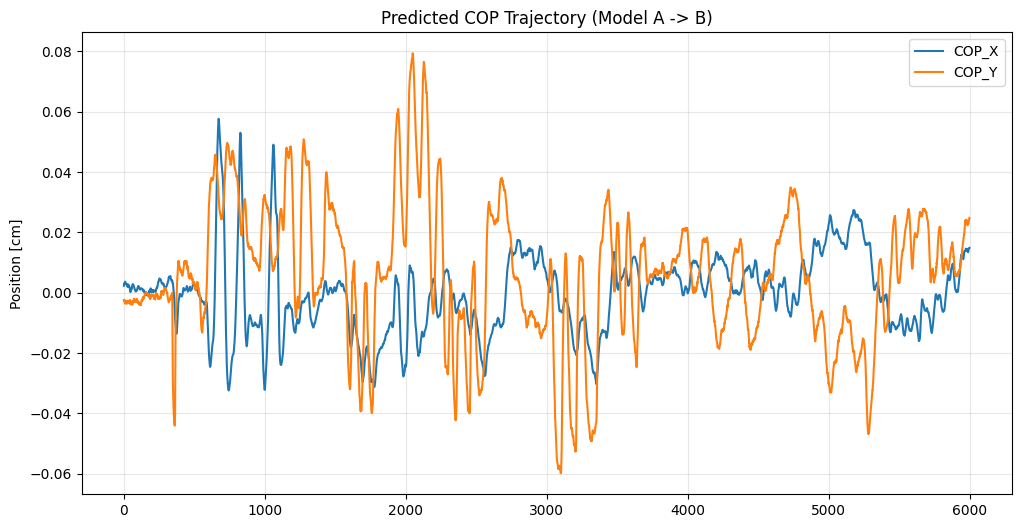

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

# ==========================================
# 1. SubjectAwareSmoother (平滑化)
# ==========================================
class SubjectAwareSmoother(BaseEstimator, TransformerMixin):
    def __init__(self, window=15):
        self.window = window

    def _apply_rolling_mean(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            X_smooth_full = self._apply_rolling_mean(X_combined)
            X_smooth = X_smooth_full.iloc[-len(X):]
        else:
            X_smooth = self._apply_rolling_mean(X)
        
        X_out[target_cols] = X_smooth
        return X_out

# ==========================================
# 2. SubjectAwareDetrender (トレンド除去)
# ==========================================
class SubjectAwareDetrender(BaseEstimator, TransformerMixin):
    def __init__(self, window=300):
        self.window = window

    def _calculate_trend(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_roll = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        
        # GroupBy Rolling
        rolled = df.groupby('subject_id')[cols_to_roll].rolling(window=self.window, min_periods=1).mean()
        rolled = rolled.reset_index(level=0, drop=True).sort_index()
        return rolled

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            X_combined = pd.concat([X_context.iloc[-self.window:], X])
            trend_full = self._calculate_trend(X_combined)
            trend = trend_full.iloc[-len(X):]
        else:
            trend = self._calculate_trend(X)

        X_out[target_cols] = X_out[target_cols] - trend
        return X_out

# ==========================================
# SubjectAwareDifferencer (差分化)
# ==========================================
class SubjectAwareDifferencer(BaseEstimator, TransformerMixin):
    """
    Subjectごとに1階差分(Diff)をとるクラス
    Test時はContextを受け取り、境界値のDiffも正しく計算する
    """
    def __init__(self):
        pass

    def _apply_diff(self, df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        cols_to_diff = [c for c in numeric_cols if c != 'subject_id']
        
        if 'subject_id' not in df.columns:
            return df[cols_to_diff].diff()
        
        # GroupBy Diff
        diffed = df.groupby('subject_id')[cols_to_diff].diff()
        # diffの結果はindexが維持されるのでそのまま返す
        return diffed

    def fit(self, X, y=None):
        return self

    def transform(self, X, X_context=None):
        X_out = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        target_cols = [c for c in numeric_cols if c != 'subject_id']

        if X_context is not None:
            # Context結合 (diffには直前1行あればいいが、念のため少し多めに)
            X_combined = pd.concat([X_context.iloc[-5:], X])
            diff_full = self._apply_diff(X_combined)
            diff = diff_full.iloc[-len(X):]
        else:
            diff = self._apply_diff(X)
        
        X_out[target_cols] = diff
        return X_out


# ==========================================
# 3. CausalFeatureGenerator (ラグ特徴量生成)
# ==========================================
class CausalFeatureGenerator:
    def __init__(self, control_lags):
        self.control_lags = control_lags

    def transform(self, X, y_target_col):
        features_df = pd.DataFrame(index=X.index)
        
        if 'subject_id' not in X.columns:
            groups = X.assign(temp_id=1).groupby('temp_id')
        else:
            groups = X.groupby('subject_id')

        # 使用する特徴量候補
        feature_vars = ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered','COP_X_phys','COP_Y_phys','pedal','steer','interact_steer_pedal',
       'op_magnitude', 'phys_pitch', 'phys_roll', 'phys_torsion', 'COP_radius',
       'COP_angle', 'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy']
        
        for feature_var in feature_vars:
            if feature_var not in X.columns: continue
            
            control_key = f"{feature_var}→{y_target_col}"
            optimal_lag = self.control_lags.get(control_key, 0)
            
            # 指定ラグ周辺を含めて生成
            # for lag in range(1, optimal_lag + 10):
            #     features_df[f"{feature_var}_lag{lag}"] = groups[feature_var].shift(lag)

            # 1. 探索範囲を決める (例: 最適値の前後5ポイント)
            # ※ optimal_lag が 0 の場合は、何もしないか、直近だけ取る
            if optimal_lag == 0:
                lags_to_generate = [1] # デフォルト
            else:
                # 下限は必ず 1以上 (未来を見ないため)
                start_lag = max(1, optimal_lag - 5)
                end_lag   = optimal_lag + 5
                
                # 範囲生成
                lags_to_generate = range(start_lag, end_lag + 1)

            # 2. 指定されたラグだけを生成
            for lag in lags_to_generate:
                col_name = f"{feature_var}_lag{lag}"
                features_df[col_name] = groups[feature_var].shift(lag)

        return features_df

# ==========================================
# 4. SubjectAwareStandardizer (標準化)
# ==========================================
class SubjectAwareStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stats_per_subject = {} 
        self.global_stats = {}      
        self.target_cols = []

    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        self.target_cols = [c for c in numeric_cols if c != 'subject_id']

        # 1. Global Stats
        for col in self.target_cols:
            mean, std = X[col].mean(), X[col].std()
            if std == 0: std = 1.0
            self.global_stats[col] = (mean, std)

        # 2. Subject Stats
        if 'subject_id' in X.columns:
            grouped = X.groupby('subject_id')[self.target_cols].agg(['mean', 'std'])
            for subject_id, row in grouped.iterrows():
                self.stats_per_subject[subject_id] = {}
                for col in self.target_cols:
                    m = row[(col, 'mean')]
                    s = row[(col, 'std')]
                    if pd.isna(s) or s == 0: s = 1.0
                    self.stats_per_subject[subject_id][col] = (m, s)
        return self

    def transform(self, X):
        X_out = X.copy()
        
        # Subjectが無い場合
        if 'subject_id' not in X.columns:
            for col in self.target_cols:
                if col in X_out.columns:
                    m, s = self.global_stats[col]
                    X_out[col] = (X_out[col] - m) / s
            return X_out

        # Subjectがある場合 (Mapによる高速化)
        for col in self.target_cols:
            if col not in X_out.columns: continue

            mean_map, std_map = {}, {}
            g_mean, g_std = self.global_stats[col]

            for uid in X_out['subject_id'].unique():
                if uid in self.stats_per_subject:
                    mean_map[uid] = self.stats_per_subject[uid][col][0]
                    std_map[uid]  = self.stats_per_subject[uid][col][1]
                else:
                    mean_map[uid] = g_mean
                    std_map[uid]  = g_std
            
            means = X_out['subject_id'].map(mean_map)
            stds  = X_out['subject_id'].map(std_map)
            X_out[col] = (X_out[col] - means) / stds

        return X_out

# ==========================================
# 5. SimplePLSModel
# ==========================================
class SimplePLSModel:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.model = None

    def fit(self, X, y):
        self.model = PLSRegression(n_components=min(self.n_components, X.shape[1]))
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)


from sklearn.model_selection import KFold, GroupKFold, cross_val_score

class AutoTunedPLSModel:
    def __init__(self, max_components=30, cv_splits=5, cv_method='random'):
        """
        cv_method: 'random' (KFold) or 'group' (GroupKFold)
        """
        self.max_components = max_components
        self.cv_splits = cv_splits
        self.cv_method = cv_method
        self.best_n_components_ = None
        self.model = None

    def fit(self, X, y, groups=None):
        """
        groups: Inner CVで GroupKFold を使うためのグルーピング情報 (subject_id等)
        """
        # 探索範囲
        n_features = X.shape[1]
        limit = min(n_features, self.max_components)
        if limit < 1: limit = 1
        candidate_components = range(1, limit + 1)
        
        best_score = float('inf')
        best_n = 1
        
        # CV分割器の選択
        if self.cv_method == 'group':
            if groups is None:
                raise ValueError("cv_method='group' requires 'groups' argument in fit().")
            
            # グループ数がsplit数より少ない場合の安全策
            n_groups = len(np.unique(groups))
            actual_splits = min(self.cv_splits, n_groups)
            
            cv = GroupKFold(n_splits=actual_splits)
        else:
            # ランダム分割 (従来通り)
            cv = KFold(n_splits=self.cv_splits, shuffle=True, random_state=42)
        
        # グリッドサーチ
        for n in candidate_components:
            pls = PLSRegression(n_components=n, scale=False)
            
            # groups引数は、KFoldの場合は無視され、GroupKFoldの場合のみ使われる
            scores = cross_val_score(pls, X, y, cv=cv, groups=groups, scoring='neg_mean_squared_error')
            mse_score = -np.mean(scores)
            
            if mse_score < best_score:
                best_score = mse_score
                best_n = n
        
        # 最適値で学習
        self.best_n_components_ = best_n
        self.model = PLSRegression(n_components=best_n, scale=False)
        self.model.fit(X, y)
        
        return self

    def predict(self, X):
        return self.model.predict(X)

from sklearn.metrics import mean_squared_error,mean_absolute_error # 追加
def plot_prediction_waveform(y_true, y_pred, y_col, fold_id=None, score=None, mae=None, rmse=None):
    """
    RMSE引数を追加
    """
    plt.figure(figsize=(15, 4))
    
    plt.plot(y_true.values, label="True", linewidth=2, alpha=0.85)
    plt.plot(y_pred.values, label="Pred", linewidth=1.5, linestyle='--', alpha=0.85)
    
    title_parts = [f"Prediction vs True - {y_col}"]
    if fold_id is not None:
        title_parts.append(f"({fold_id})")
    
    score_text = []
    if score is not None: score_text.append(f"R2={score:.3f}")
    if mae is not None:   score_text.append(f"MAE={mae:.3f}")
    if rmse is not None:  score_text.append(f"RMSE={rmse:.3f}") # ★追加
        
    if score_text:
        title_parts.append(" | " + ", ".join(score_text))
        
    plt.title(" ".join(title_parts), fontsize=14)
    plt.xlabel("Time (samples)")
    plt.ylabel(y_col)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    
def plot_feature_importance(pls_model, feature_names, y_col):
    """
    PLS の特徴量重要度を棒グラフで可視化する
    - pls_model : SimplePLSModel.model (PLSRegression)
    - feature_names : X の列名
    - y_col : どのターゲット向けのモデルか
    """
    # 係数を取得（shape: n_features x n_targets）
    coefs = pls_model.coef_.flatten()

    # 重要度 = |係数|
    importance = np.abs(coefs)

    # 大きい順にソート
    idx = np.argsort(importance)[::-1]
    sorted_importance = importance[idx]
    sorted_features = np.array(feature_names)[idx]

    plt.figure(figsize=(10, 5))
    plt.bar(sorted_features[:20], sorted_importance[:20])  # 上位20個だけ描画（多すぎるため）
    plt.xticks(rotation=90)
    plt.title(f"Feature Importance (PLS coef) for {y_col}")
    plt.tight_layout()
    plt.show()
    

def plot_residual_acorrelation(y_true, y_pred, y_col):
    """
    残差の自己相関（Autocorrelation）をプロットする関数
    修正点: y_true が DataFrame の場合に Series に変換する処理を追加
    """
    # ★修正: y_true が DataFrame なら Series (1次元) に変換する
    if isinstance(y_true, pd.DataFrame):
        # 1列目のデータをSeriesとして取り出す
        y_true = y_true.iloc[:, 0]
    
    # 残差の計算 (Series同士の計算になるので安全)
    resid = y_true - y_pred
    
    # NaNや無限大が含まれているとエラーになるので除去
    resid = resid.dropna()
    resid = resid[np.isfinite(resid)]
    
    # numpy array に変換して flatten (念には念を入れて1次元化)
    resid_values = resid.values.flatten()

    plt.figure(figsize=(10, 5))
    
    # acorrプロット
    # maxlags: データ点数が少ない場合は len(resid)//2 程度に抑えるのが安全
    lags = min(50, len(resid_values) // 2)
    
    plt.acorr(resid_values, maxlags=lags, usevlines=True, normed=True, lw=2)
    
    plt.title(f"Residual Autocorrelation - {y_col} (Check for Spurious Regression)")
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.grid(True, alpha=0.3)
    plt.ylim(-0.2, 1.1) 
    
    # 目安ライン
    plt.axhline(0, color='black', lw=1)
    plt.axhline(0.1, color='red', linestyle='--', alpha=0.3)
    plt.axhline(-0.1, color='red', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


from sklearn.model_selection import KFold, cross_val_score
from sklearn.cross_decomposition import PLSRegression
import numpy as np
import pandas as pd


class RobustLagModel:
    """
    推論時に動作タイプを仮定しない保守的なラグモデル
    """
    
    def __init__(self, lag_strategy='conservative', window_size=300, step_size=50):
        self.lag_strategy = lag_strategy
        self.window_size = window_size
        self.step_size = step_size
        self.default_lags = None
        self.local_lags_history = None
        
    def compute_robust_lags(self, X_train, y_train):
        """
        訓練データからロバストなラグを計算
        
        Parameters
        ----------
        X_train : pd.DataFrame
            訓練データの特徴量
        y_train : pd.DataFrame
            訓練データのターゲット
            
        Returns
        -------
        dict
            ロバストなラグの辞書
        """
        print(f"🔧 {self.lag_strategy}戦略でロバストラグを計算中...")
        
        # 局所ラグの分析
        self.local_lags_history = self._analyze_local_lags(X_train, y_train)
        
        # 戦略に応じたラグ計算
        if self.lag_strategy == 'median':
            self.default_lags = self._compute_median_lags()
        elif self.lag_strategy == 'conservative':
            self.default_lags = self._compute_conservative_lags()
        elif self.lag_strategy == 'weighted':
            self.default_lags = self._compute_weighted_lags()
        elif self.lag_strategy == 'mode':
            self.default_lags = self._compute_mode_lags()
        else:
            raise ValueError(f"未知の戦略: {self.lag_strategy}")
        
        self._print_lag_summary()
        return self.default_lags
    
    def _analyze_local_lags(self, X, y):
        """スライディングウィンドウで局所ラグを分析"""
        local_lags = []
        n_windows = (len(X) - self.window_size) // self.step_size
        
        print(f"📊 局所ラグ分析: {n_windows}ウィンドウ")
        
        for i in range(n_windows):
            start_idx = i * self.step_size
            end_idx = start_idx + self.window_size
            
            X_window = X.iloc[start_idx:end_idx]
            y_window = y.iloc[start_idx:end_idx]
            
            # このウィンドウでのラグを計算
            try:
                window_lags = self._find_optimal_lags_simple(X_window, y_window, max_lag=15)
                
                window_info = {
                    'start_idx': start_idx,
                    'end_idx': end_idx,
                    'lags': window_lags,
                    'pedal_mean': X_window['pedal'].mean() if 'pedal' in X_window.columns else 0,
                    'steer_std': X_window['steer'].std() if 'steer' in X_window.columns else 0
                }
                
                local_lags.append(window_info)
                
            except Exception as e:
                continue
        
        print(f"✅ 局所ラグ分析完了: {len(local_lags)}ウィンドウ")
        return local_lags
    
    def _find_optimal_lags_simple(self, X, y, max_lag=15):
        """簡易版ラグ探索"""
        lags_dict = {}
        
        target_features = ['F1', 'F2', 'F3', 'F4', 'FX_filtered', 'FY_filtered','COP_X_phys','COP_Y_phys','pedal','steer','interact_steer_pedal', 'op_magnitude', 'phys_pitch', 'phys_roll', 'phys_torsion', 'COP_radius',
        'COP_angle', 'steer_COPx', 'steer_COPy', 'pedal_COPx', 'pedal_COPy']
        for y_col in y.columns:
            for control_var in target_features:
                if control_var not in X.columns:
                    continue
                    
                key = f"{control_var}→{y_col}"
                
                try:
                    # 簡易な相互相関計算
                    x_signal = X[control_var].values
                    y_signal = y[y_col].values
                    
                    # NaN除去
                    valid_mask = ~np.isnan(x_signal) & ~np.isnan(y_signal)
                    x_valid = x_signal[valid_mask]
                    y_valid = y_signal[valid_mask]
                    
                    if len(x_valid) > 50:
                        # 正規化
                        x_norm = (x_valid - np.mean(x_valid)) / (np.std(x_valid) + 1e-8)
                        y_norm = (y_valid - np.mean(y_valid)) / (np.std(y_valid) + 1e-8)
                        
                        # 相互相関
                        correlation = np.correlate(y_norm, x_norm, mode='full')
                        lags = np.arange(-len(x_valid)+1, len(y_valid))
                        
                        # 正のラグのみ
                        positive_mask = (lags >= 0) & (lags <= max_lag)
                        positive_corr = correlation[positive_mask]
                        positive_lags = lags[positive_mask]
                        
                        if len(positive_corr) > 0:
                            best_lag = positive_lags[np.argmax(positive_corr)]
                            lags_dict[key] = int(best_lag)
                            
                except Exception as e:
                    continue
        
        return lags_dict
    
    def _compute_median_lags(self):
        """局所ラグの中央値を使用"""
        median_lags = {}
        
        # 全てのターゲット変数と操作変数の組み合わせ
        target_vars = set()
        control_vars = set()
        
        for window in self.local_lags_history:
            for key in window['lags'].keys():
                control_var, target_var = key.split('→')
                target_vars.add(target_var)
                control_vars.add(control_var)
        
        for target_var in target_vars:
            for control_var in control_vars:
                key = f"{control_var}→{target_var}"
                lags = []
                
                for window in self.local_lags_history:
                    if key in window['lags']:
                        lags.append(window['lags'][key])
                
                if lags:
                    median_lags[key] = int(np.median(lags))
        
        return median_lags
    
    def _compute_conservative_lags(self):
        """保守的なラグ（中央値 + 安全マージン）"""
        median_lags = self._compute_median_lags()
        conservative_lags = {}
        
        for key, lag in median_lags.items():
            # 中央値 + 1（安全マージン）
            conservative_lag = min(lag + 1, 10)  # 最大10サンプル
            conservative_lags[key] = conservative_lag
        
        return conservative_lags
    
    def _compute_mode_lags(self):
        """最頻値を使用"""
        from scipy import stats
        
        mode_lags = {}
        
        target_vars = set()
        control_vars = set()
        
        for window in self.local_lags_history:
            for key in window['lags'].keys():
                control_var, target_var = key.split('→')
                target_vars.add(target_var)
                control_vars.add(control_var)
        
        for target_var in target_vars:
            for control_var in control_vars:
                key = f"{control_var}→{target_var}"
                lags = []
                
                for window in self.local_lags_history:
                    if key in window['lags']:
                        lags.append(window['lags'][key])
                
                if lags:
                    mode_result = stats.mode(lags)
                    mode_lags[key] = int(mode_result.mode)
        
        return mode_lags
    
    def _compute_weighted_lags(self):
        """操作強度で重み付けしたラグ"""
        weighted_lags = {}
        
        # まず基本の中央値を計算
        median_lags = self._compute_median_lags()
        
        # 操作強度に基づいて調整（ここでは簡易実装）
        for key, median_lag in median_lags.items():
            control_var = key.split('→')[0]
            
            # 操作強度が高いウィンドウのラグを重視
            high_intensity_lags = []
            
            for window in self.local_lags_history:
                if key in window['lags']:
                    if control_var == 'pedal' and window['pedal_mean'] > 0.5:
                        high_intensity_lags.append(window['lags'][key])
                    elif control_var == 'steer' and window['steer_std'] > 0.3:
                        high_intensity_lags.append(window['lags'][key])
            
            if high_intensity_lags:
                # 高強度時のラグを使用
                weighted_lags[key] = int(np.median(high_intensity_lags))
            else:
                # なければ中央値を使用
                weighted_lags[key] = median_lag
        
        return weighted_lags
    
    def _print_lag_summary(self):
        """ラグのサマリーを表示"""
        print("\n" + "="*50)
        print("📊 ロバストラグ計算結果")
        print("="*50)
        
        if not self.default_lags:
            print("❌ ラグが計算されていません")
            return
        
        # ターゲット変数ごとにグループ化して表示
        target_groups = {}
        for key, lag in self.default_lags.items():
            control_var, target_var = key.split('→')
            if target_var not in target_groups:
                target_groups[target_var] = {}
            target_groups[target_var][control_var] = lag
        
        for target_var, lags in target_groups.items():
            print(f"\n🎯 {target_var}:")
            for control_var, lag in lags.items():
                print(f"   {control_var}: {lag}サンプル")
        
        # 統計情報
        all_lags = list(self.default_lags.values())
        print(f"\n📈 統計:")
        print(f"   平均: {np.mean(all_lags):.2f}サンプル")
        print(f"   標準偏差: {np.std(all_lags):.2f}サンプル")
        print(f"   範囲: {min(all_lags)}-{max(all_lags)}サンプル")
    
    def get_lag_statistics(self):
        """ラグの統計情報を取得"""
        if not self.local_lags_history:
            return None
        
        stats = {}
        for key in self.default_lags.keys():
            lags = [window['lags'].get(key, np.nan) for window in self.local_lags_history 
                   if key in window['lags']]
            lags = [lag for lag in lags if not np.isnan(lag)]
            
            if lags:
                stats[key] = {
                    'mean': np.mean(lags),
                    'std': np.std(lags),
                    'median': np.median(lags),
                    'min': np.min(lags),
                    'max': np.max(lags),
                    'n_windows': len(lags)
                }
        
        return stats
    
    def visualize_lag_distribution(self, target_var=None):
        """ラグの分布を可視化"""
        if not self.local_lags_history:
            print("❌ ラグデータがありません")
            return
        
        import matplotlib.pyplot as plt
        
        # 表示するキーを選択
        if target_var:
            keys_to_plot = [key for key in self.default_lags.keys() if target_var in key]
        else:
            keys_to_plot = list(self.default_lags.keys())[:4]  # 最大4つ
        
        n_plots = len(keys_to_plot)
        if n_plots == 0:
            return
        
        fig, axes = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
        if n_plots == 1:
            axes = [axes]
        
        for idx, key in enumerate(keys_to_plot):
            if idx >= len(axes):
                break
                
            lags = [window['lags'].get(key, np.nan) for window in self.local_lags_history 
                   if key in window['lags']]
            lags = [lag for lag in lags if not np.isnan(lag)]
            
            if lags:
                axes[idx].hist(lags, bins=10, alpha=0.7, edgecolor='black')
                axes[idx].axvline(np.mean(lags), color='red', linestyle='--', label='平均')
                axes[idx].axvline(np.median(lags), color='green', linestyle='--', label='中央値')
                axes[idx].set_xlabel('ラグ (サンプル)')
                axes[idx].set_ylabel('頻度')
                axes[idx].set_title(f'{key}\n(n={len(lags)})')
                axes[idx].legend()
                axes[idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# # 1. モデルの初期化
# robust_lag_model = RobustLagModel(lag_strategy='conservative')

# # 2. ロバストなラグを計算
# robust_lags = robust_lag_model.compute_robust_lags(X_raw, y_raw)


class AutoLagSelector:
    """
    最適なラグ範囲を交差検証で探索・選択するクラス
    修正点: PLS成分数を特徴量数に合わせて動的に調整
    """
    def __init__(self, base_lags, search_range=[-5, 0, 5], cv_splits=3):
        self.base_lags = base_lags
        self.search_range = search_range
        self.cv_splits = cv_splits
        self.best_lags_ = {}

    def fit(self, X, y, groups=None):
        print(f"🔎 ラグ最適化を開始 (CV={self.cv_splits})...")
        
        # Inner CV設定
        if groups is not None:
            from sklearn.model_selection import GroupKFold
            kf = GroupKFold(n_splits=self.cv_splits)
        else:
            kf = KFold(n_splits=self.cv_splits, shuffle=True, random_state=42)

        best_score = float('inf')
        best_offset = 0
        
        for offset in self.search_range:
            # 1. 仮のラグ設定
            current_lags = {k: max(1, v + offset) for k, v in self.base_lags.items()}
            
            # 2. 特徴量生成
            X_temp = self._generate_lagged_features(X, current_lags)
            
            # 3. 欠損除去
            valid_idx = X_temp.dropna().index.intersection(y.dropna().index)
            if len(valid_idx) == 0:
                print(f"  Offset {offset:+d}: Skipped (No valid data)")
                continue
                
            X_cv = X_temp.loc[valid_idx]
            y_cv = y.loc[valid_idx]
            groups_cv = groups[X_temp.index.get_indexer(valid_idx)] if groups is not None else None
            
            # ★修正箇所: 成分数を特徴量数を超えないように制限する
            n_features = X_cv.shape[1]
            if n_features == 0: continue
            
            # 最大でも5、かつ特徴量数以下にする
            n_comp_safe = min(5, n_features)
            
            # 4. PLSで評価
            pls = PLSRegression(n_components=n_comp_safe, scale=True)
            
            try:
                scores = cross_val_score(pls, X_cv, y_cv, cv=kf, groups=groups_cv, scoring='neg_mean_squared_error')
                mean_mse = -np.mean(scores)
                print(f"  Offset {offset:+d}: MSE = {mean_mse:.4f} (n_comp={n_comp_safe})")
                
                if mean_mse < best_score:
                    best_score = mean_mse
                    best_offset = offset
            except ValueError as e:
                print(f"  Offset {offset:+d}: Failed ({e})")
                continue
        
        print(f"✅ 最適オフセット: {best_offset:+d}")
        
        self.best_lags_ = {k: max(1, v + best_offset) for k, v in self.base_lags.items()}
        return self

    def _generate_lagged_features(self, X, lags_dict):
        X_out = pd.DataFrame(index=X.index)
        if 'subject_id' in X.columns:
            grouper = X.groupby('subject_id')
        else:
            grouper = None
            
        for col_name, lag in lags_dict.items():
            feature = col_name.split('→')[0]
            if feature not in X.columns: continue
            
            # 簡易評価のため、指定ラグのピンポイント1つだけ生成して高速化
            # (ここを増やすと特徴量が増え、エラーは減るが計算が遅くなる)
            l = lag
            if l < 1: l = 1
            col_feat = f"{feature}_lag{l}"
            
            if grouper is not None:
                X_out[col_feat] = grouper[feature].shift(l)
            else:
                X_out[col_feat] = X[feature].shift(l)
                    
        return X_out
    
    

my_optimal_lags = {

    # =========================
    # 🎯 圧力中心列_2
    # =========================
    'COP_X_phys→圧力中心列_2': 10,
    'steer_COPx→圧力中心列_2': 10,
    'COP_radius→圧力中心列_2': 10,
    'steer_COPy→圧力中心列_2': 10,
    'pedal_COPy→圧力中心列_2': 10,
    'F4→圧力中心列_2': 10,
    'interact_steer_pedal→圧力中心列_2': 10,
    'phys_torsion→圧力中心列_2': 10,
    'F2→圧力中心列_2': 10,
    'phys_pitch→圧力中心列_2': 10,
    'op_magnitude→圧力中心列_2': 8,
    'pedal_COPx→圧力中心列_2': 6,
    'pedal→圧力中心列_2': 6,
    'FY_filtered→圧力中心列_2': 5,
    'COP_angle→圧力中心列_2': 1,
    'phys_roll→圧力中心列_2': 1,
    'F3→圧力中心列_2': 1,
    'F1→圧力中心列_2': 1,
    'FX_filtered→圧力中心列_2': 1,
    'COP_Y_phys→圧力中心列_2': 1,
    'steer→圧力中心列_2': 1,


    # =========================
    # 🎯 荷重(N)_1
    # =========================
    'COP_X_phys→荷重(N)_1': 10,
    'steer_COPx→荷重(N)_1': 10,
    'COP_radius→荷重(N)_1': 10,
    'steer_COPy→荷重(N)_1': 10,
    'pedal_COPy→荷重(N)_1': 10,
    'F4→荷重(N)_1': 10,
    'interact_steer_pedal→荷重(N)_1': 10,
    'phys_torsion→荷重(N)_1': 10,
    'F2→荷重(N)_1': 10,
    'phys_pitch→荷重(N)_1': 10,
    'op_magnitude→荷重(N)_1': 8,
    'pedal_COPx→荷重(N)_1': 6,
    'pedal→荷重(N)_1': 6,
    'FY_filtered→荷重(N)_1': 5,
    'COP_angle→荷重(N)_1': 1,
    'phys_roll→荷重(N)_1': 1,
    'F3→荷重(N)_1': 1,
    'F1→荷重(N)_1': 1,
    'FX_filtered→荷重(N)_1': 1,
    'COP_Y_phys→荷重(N)_1': 1,
    'steer→荷重(N)_1': 1,


    # =========================
    # 🎯 圧力中心行_1
    # =========================
    'COP_X_phys→圧力中心行_1': 10,
    'steer_COPx→圧力中心行_1': 10,
    'COP_radius→圧力中心行_1': 10,
    'steer_COPy→圧力中心行_1': 10,
    'pedal_COPy→圧力中心行_1': 10,
    'F4→圧力中心行_1': 10,
    'interact_steer_pedal→圧力中心行_1': 10,
    'phys_torsion→圧力中心行_1': 10,
    'F2→圧力中心行_1': 10,
    'phys_pitch→圧力中心行_1': 10,
    'op_magnitude→圧力中心行_1': 8,
    'pedal_COPx→圧力中心行_1': 6,
    'pedal→圧力中心行_1': 6,
    'FY_filtered→圧力中心行_1': 5,
    'COP_angle→圧力中心行_1': 1,
    'phys_roll→圧力中心行_1': 1,
    'F3→圧力中心行_1': 1,
    'F1→圧力中心行_1': 1,
    'FX_filtered→圧力中心行_1': 1,
    'COP_Y_phys→圧力中心行_1': 1,
    'steer→圧力中心行_1': 1,


    # =========================
    # 🎯 圧力中心列_1
    # =========================
    'COP_X_phys→圧力中心列_1': 10,
    'steer_COPx→圧力中心列_1': 10,
    'COP_radius→圧力中心列_1': 10,
    'steer_COPy→圧力中心列_1': 10,
    'pedal_COPy→圧力中心列_1': 10,
    'F4→圧力中心列_1': 10,
    'interact_steer_pedal→圧力中心列_1': 10,
    'phys_torsion→圧力中心列_1': 10,
    'F2→圧力中心列_1': 10,
    'phys_pitch→圧力中心列_1': 10,
    'op_magnitude→圧力中心列_1': 8,
    'pedal_COPx→圧力中心列_1': 6,
    'pedal→圧力中心列_1': 6,
    'FY_filtered→圧力中心列_1': 5,
    'COP_angle→圧力中心列_1': 1,
    'phys_roll→圧力中心列_1': 1,
    'F3→圧力中心列_1': 1,
    'F1→圧力中心列_1': 1,
    'FX_filtered→圧力中心列_1': 1,
    'COP_Y_phys→圧力中心列_1': 1,
    'steer→圧力中心列_1': 1,


    # =========================
    # 🎯 ピーク圧力_1
    # =========================
    'COP_X_phys→ピーク圧力_1': 10,
    'steer_COPx→ピーク圧力_1': 10,
    'COP_radius→ピーク圧力_1': 10,
    'steer_COPy→ピーク圧力_1': 10,
    'pedal_COPy→ピーク圧力_1': 10,
    'F4→ピーク圧力_1': 10,
    'interact_steer_pedal→ピーク圧力_1': 10,
    'phys_torsion→ピーク圧力_1': 10,
    'F2→ピーク圧力_1': 10,
    'phys_pitch→ピーク圧力_1': 10,
    'op_magnitude→ピーク圧力_1': 8,
    'pedal_COPx→ピーク圧力_1': 6,
    'pedal→ピーク圧力_1': 6,
    'FY_filtered→ピーク圧力_1': 5,
    'COP_angle→ピーク圧力_1': 1,
    'phys_roll→ピーク圧力_1': 1,
    'F3→ピーク圧力_1': 1,
    'F1→ピーク圧力_1': 1,
    'FX_filtered→ピーク圧力_1': 1,
    'COP_Y_phys→ピーク圧力_1': 1,
    'steer→ピーク圧力_1': 1,


    # =========================
    # 🎯 接触 %_1
    # =========================
    'COP_X_phys→接触 %_1': 10,
    'steer_COPx→接触 %_1': 10,
    'COP_radius→接触 %_1': 10,
    'steer_COPy→接触 %_1': 10,
    'pedal_COPy→接触 %_1': 10,
    'F4→接触 %_1': 10,
    'interact_steer_pedal→接触 %_1': 10,
    'phys_torsion→接触 %_1': 10,
    'F2→接触 %_1': 10,
    'phys_pitch→接触 %_1': 10,
    'op_magnitude→接触 %_1': 8,
    'pedal_COPx→接触 %_1': 6,
    'pedal→接触 %_1': 6,
    'FY_filtered→接触 %_1': 5,
    'COP_angle→接触 %_1': 1,
    'phys_roll→接触 %_1': 1,
    'F3→接触 %_1': 1,
    'F1→接触 %_1': 1,
    'FX_filtered→接触 %_1': 1,
    'COP_Y_phys→接触 %_1': 1,
    'steer→接触 %_1': 1,


    # =========================
    # 🎯 接触 %_2
    # =========================
    'COP_X_phys→接触 %_2': 10,
    'steer_COPx→接触 %_2': 10,
    'COP_radius→接触 %_2': 10,
    'steer_COPy→接触 %_2': 10,
    'pedal_COPy→接触 %_2': 10,
    'F4→接触 %_2': 10,
    'interact_steer_pedal→接触 %_2': 10,
    'phys_torsion→接触 %_2': 10,
    'F2→接触 %_2': 10,
    'phys_pitch→接触 %_2': 10,
    'op_magnitude→接触 %_2': 8,
    'pedal_COPx→接触 %_2': 6,
    'pedal→接触 %_2': 6,
    'FY_filtered→接触 %_2': 5,
    'COP_angle→接触 %_2': 1,
    'phys_roll→接触 %_2': 1,
    'F3→接触 %_2': 1,
    'F1→接触 %_2': 1,
    'FX_filtered→接触 %_2': 1,
    'COP_Y_phys→接触 %_2': 1,
    'steer→接触 %_2': 1,
}


import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt


class BridgeInferenceEngine:
    def __init__(self, model_a_path, model_b_path):
        """
        2つのモデルファイルを読み込んで初期化する
        """
        print(f"📂 Loading Model A from {model_a_path}...")
        self.artifacts_a = joblib.load(model_a_path)
        
        print(f"📂 Loading Model B from {model_b_path}...")
        self.artifacts_b = joblib.load(model_b_path)
        
        # --- Model A の展開 ---
        # 辞書のキー: 'models', 'input_columns', 'preprocessors'
        self.models_A = self.artifacts_a['models'] 
        self.input_cols_A = self.artifacts_a['input_columns']
        
        # --- Model B の展開 ---
        # 辞書のキー: 'models', 'features', 'targets', 'calib_samples'
        self.models_B = self.artifacts_b['models']
        self.input_cols_B_features = self.artifacts_b['features'] # Model Bの入力順序
        self.calib_samples = self.artifacts_b['calib_samples']    # 初期値計算用のサンプル数
        
        # --- 前処理器の初期化 ---
        # Model A学習時と同じ設定で初期化
        params = self.artifacts_a.get('preprocessors', {})
        # self.smoother = utils.SubjectAwareSmoother(window=params.get('smooth_window', 15))
        # self.detrender = utils.SubjectAwareDetrender(window=params.get('detrend_window', 300))
        self.smoother = SubjectAwareSmoother(window=params.get('smooth_window', 15))
        self.detrender = SubjectAwareDetrender(window=params.get('detrend_window', 300))
        
        print("✅ Inference Engine Initialized.")

    def predict(self, X_new_raw, initial_cop_guess={'COP_X':0, 'COP_Y':0}):
        """
        X_new_raw: 新しいセンサデータ (DataFrame)
        initial_cop_guess: 推定開始時の本物COPの初期位置
        """
        # =================================================
        # 1. Model A Preprocessing (Smooth -> Detrend)
        # =================================================
        X_new = X_new_raw.copy()
        
        # subject_idが無い場合はダミーを入れる（Scaler等の動作のため）
        if 'subject_id' not in X_new.columns:
            X_new['subject_id'] = 1 
            
        # 前処理適用
        X_smooth = self.smoother.transform(X_new)
        X_detrend = self.detrender.transform(X_smooth)
        
        # =================================================
        # 2. Model A Prediction (Diff予測)
        # =================================================
        y_pred_diff_dict = {}
        
        for y_col, assets in self.models_A.items():
            model_pls = assets['model']
            scaler = assets['scaler_x']
            lags = assets['lags']
            
            # ラグ特徴量生成
            # (ここでは保存されたラグ定義を使ってGeneratorを都度生成)
            gen = CausalFeatureGenerator(lags)
            X_feats = gen.transform(X_detrend, y_col)
            
            # ラグによるNaNを0埋め (推論時はデータを捨てられないため)
            X_feats = X_feats.fillna(0)
            
            # SubjectID復帰 & 標準化
            X_feats['subject_id'] = X_new['subject_id'].values
            
            # Scaler適用 (subject_id列は自動で無視または処理されるが、念のためdropして渡すか任せる)
            # SubjectAwareStandardizerはsubject_id列を必要とするのでそのまま渡す
            X_scaled = scaler.transform(X_feats).drop(columns=['subject_id'], errors='ignore')
            
            # 予測 (Diff)
            pred_diff = model_pls.predict(X_scaled)
            y_pred_diff_dict[y_col] = pred_diff.flatten()
            
        # DataFrame化 (差分データ)
        df_pred_diff = pd.DataFrame(y_pred_diff_dict, index=X_new.index)
        
        # =================================================
        # 3. 🌉 Bridge: Integration (積分)
        # =================================================
        # 差分(Diff)の累積和をとる → 「初期値を0とした相対変位」になる
        df_pred_relative = df_pred_diff.cumsum()
        
        # =================================================
        # 4. Model B Input Preparation
        # =================================================
        # Model B の入力データを作成（Aの予測値 + 操作量などの他の特徴量）
        df_input_B = df_pred_relative.copy()
        
        # Xにある操作量 (pedal, steer) などを結合
        # Model Bは「初期値からの変位」を学習しているので、入力Xも初期値を引く
        for col in ['pedal', 'steer']:
            if col in X_new_raw.columns:
                # 最初のNサンプルの平均を初期値として引く
                initial_val = X_new_raw[col].iloc[:self.calib_samples].mean()
                df_input_B[col] = X_new_raw[col] - initial_val
            else:
                df_input_B[col] = 0

        # Model B に必要なカラム順序に整列
        # 足りない列があればエラーを出すか0埋めする
        missing_cols = set(self.input_cols_B_features) - set(df_input_B.columns)
        if missing_cols:
            print(f"⚠️ Warning: Missing columns for Model B: {missing_cols}. Filling with 0.")
            for c in missing_cols:
                df_input_B[c] = 0
                
        X_b_final = df_input_B[self.input_cols_B_features]
        
        # =================================================
        # 5. Model B Prediction (COP相対位置予測)
        # =================================================
        final_preds = {}
        for target_col, model_b in self.models_B.items():
            # 相対位置を予測 (Ridge Pipeline)
            pred_rel = model_b.predict(X_b_final)
            
            # 初期位置(推測値)を足して絶対座標にする
            final_preds[target_col] = pred_rel + initial_cop_guess.get(target_col, 0)
            
        return pd.DataFrame(final_preds, index=X_new.index)

import pickle
with open('X_raw_sample.pkl', 'rb') as f:
    X_raw = pickle.load(f)

# ==========================================
# 実行ブロック
# ==========================================
if __name__ == "__main__":
    # 1. 保存されたパスを指定
    path_a = 'model_a_test_run.pkl'
    path_b = 'model_b_trained.pkl' # 先ほど保存したBのファイル名
    
    # 2. エンジン起動
    try:
        engine = BridgeInferenceEngine(path_a, path_b)
        
        # 3. テストデータの作成 (本来は新しいデータcsvなどを読み込む)
        # ここでは X_raw (メモリにある変数) の一部を切り出してテスト
        # ※ X_raw がメモリにない場合は適宜ロードしてください
        if 'X_raw' in locals():
            print("Running prediction on subset of X_raw...")
            # インデックスが飛んでいても大丈夫なようにコピー
            X_new_sample = X_raw.iloc[0:6000].copy() 
            
            # 推論実行
            # ※ 本物COPの初期位置がわかっていれば initial_cop_guess に入れる
            df_result = engine.predict(X_new_sample, initial_cop_guess={'COP_X': 0, 'COP_Y': 0})
            
            # 結果表示
            print("\n--- Prediction Result (Head) ---")
            print(df_result.head())
            
            # 可視化
            
            df_result.plot(figsize=(12, 6), title="Predicted COP Trajectory (Model A -> B)")
            plt.grid(True, alpha=0.3)
            plt.ylabel("Position [cm]")
            plt.show()
            
            # # 軌跡（XYプロット）
            
            # plt.figure(figsize=(6, 6))
            # plt.plot(df_result['COP_X'], df_result['COP_Y'], label='Predicted Path')
            # plt.title("COP Trajectory (X-Y)")
            # plt.xlabel("COP X")
            # plt.ylabel("COP Y")
            # plt.grid(True)
            # plt.axis('equal') # アスペクト比を合わせる
            # plt.show()
            
        else:
            print("⚠️ X_raw data not found. Please load data to run prediction.")
            
    except FileNotFoundError as e:
        print(f"❌ Error: Model file not found. {e}")
    except Exception as e:
        print(f"❌ Error during inference: {e}")